# Processing results from Triton experiments
This notebook contains plotting code and processing code for analyzing and visualizing experiments ran for 5 synthetic benchmark functions.

### Aggregation and data loading code

In [1]:
import os
import re
import json
import pandas as pd
import scienceplots
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr
from tqdm.notebook import tqdm

def parse_experiment_name(name: str) -> dict:
    """Parses the detailed experiment folder name into a dictionary of parameters."""
    pattern = re.compile(
        r"(?P<surrogate>GP)-"
        r"(?P<acquisition>UCB|EI)_q(?P<quantile_level>[\d.]+)-"
        r"(?P<n_initial>\d+)init-"
        r"recal_(?P<method>[\w_.-]+)-"
        r"noisify_(?P<noisify>True|False)"
    )
    match = pattern.match(name)
    if not match:
        return {}
    return match.groupdict()

def load_all_results(base_path: str = "results_synth_data") -> pd.DataFrame:
    """
    Finds all 'metrics.json' files, parses their paths, and loads them into a pandas DataFrame.
    """
    base_path = Path(base_path)
    if not base_path.is_dir():
        print(f"Error: Directory not found at '{base_path.resolve()}'")
        return pd.DataFrame()

    metric_files = list(base_path.glob('**/metrics.json'))
    
    all_results = []
    print(f"Found {len(metric_files)} result files. Parsing...")
    for path in tqdm(metric_files):
        try:
            experiment_name = path.parts[-4]
            problem_name = path.parts[-3]
            seed_str = path.parts[-2]
            
            params = parse_experiment_name(experiment_name)
            params['problem'] = problem_name
            params['seed'] = int(seed_str.split('_')[-1])
            
            with open(path, 'r') as f:
                metrics = json.load(f)
            
            params.update(metrics)
            all_results.append(params)
        except (IndexError, ValueError) as e:
            print(f"Warning: Could not parse path '{path}'. Error: {e}")
            continue
            
    return pd.DataFrame(all_results)

def aggregate_metrics(df: pd.DataFrame, metrics_to_process: list) -> pd.DataFrame:
    """
    Groups the results by experiment and calculates the mean and standard deviation
    for specified metrics across all seeds.
    """
    if df.empty:
        return pd.DataFrame()
        
    grouping_keys = [
        'problem', 'surrogate', 'acquisition', 'quantile_level', 
        'n_initial', 'method', 'noisify'
    ]
    
    missing_keys = [key for key in grouping_keys if key not in df.columns]
    if missing_keys:
        print(f"Error: Missing grouping keys in DataFrame: {missing_keys}")
        return pd.DataFrame()

    print("Aggregating results across seeds...")
    
    aggregated_data = []
    
    grouped = df.groupby(grouping_keys)
    
    for name, group in tqdm(grouped):
        agg_row = dict(zip(grouping_keys, name))
        
        for metric in metrics_to_process:
            metric_array = np.array(group[metric].tolist())
            num_seeds = metric_array.shape[0]
            
            if metric == 'y_regret_pool':
                cumulative_regret_array = np.cumsum(metric_array, axis=1)
                agg_row['cumulative_regret_mean'] = np.mean(cumulative_regret_array, axis=0)
                agg_row['cumulative_regret_std'] = np.std(cumulative_regret_array, axis=0)
                agg_row['cumulative_regret_sem'] = np.std(cumulative_regret_array, axis=0) / np.sqrt(num_seeds)
            
            agg_row[f'{metric}_mean'] = np.mean(metric_array, axis=0)
            agg_row[f'{metric}_std'] = np.std(metric_array, axis=0)
            agg_row[f'{metric}_sem'] = np.std(metric_array, axis=0) / np.sqrt(num_seeds)
            
        aggregated_data.append(agg_row)
        
    return pd.DataFrame(aggregated_data)



def calculate_and_average_correlations(
    raw_df: pd.DataFrame,
    correlation_pairs: dict
) -> pd.DataFrame:
    """
    Calculates per-run Spearman correlations for specified metric pairs and then
    averages them across seeds for each problem and method.

    Args:
        raw_df (pd.DataFrame): The raw DataFrame from load_all_results(),
                               before any aggregation.
        correlation_pairs (dict): A dictionary where keys are the name of the
                                  correlation and values are tuples of the two
                                  metric columns to correlate.

    Returns:
        pd.DataFrame: A DataFrame with the mean and std of correlations,
                      grouped by problem and method.
    """
    if raw_df.empty:
        print("Input DataFrame is empty.")
        return pd.DataFrame()

    print("Calculating per-run correlations...")
    per_run_correlations = []

    # Iterate through each run (each row in the raw DataFrame)
    for _, row in tqdm(raw_df.iterrows(), total=len(raw_df)):
        run_data = {
            'problem': row['problem'],
            'method': row['method']
        }

        # Calculate correlation for each specified pair
        for corr_name, (metric1, metric2) in correlation_pairs.items():
            if metric1 in row and metric2 in row and \
               isinstance(row[metric1], list) and isinstance(row[metric2], list):
                # spearmanr returns a tuple (correlation, p-value)
                corr, _ = spearmanr(row[metric1], row[metric2])
                run_data[corr_name] = corr
            else:
                run_data[corr_name] = np.nan # Handle missing data

        per_run_correlations.append(run_data)

    corr_df = pd.DataFrame(per_run_correlations)

    # --- Aggregate the correlations ---
    print("Averaging correlations across seeds...")
    grouping_keys = ['problem', 'method']
    corr_columns = list(correlation_pairs.keys())
    
    # Group by problem and method, then calculate mean and std for each correlation
    agg_corr = corr_df.groupby(grouping_keys)[corr_columns].agg(['mean', 'std'])

    # Clean up the multi-level column names
    agg_corr.columns = ['_'.join(col).strip() for col in agg_corr.columns.values]
    agg_corr = agg_corr.reset_index()

    return agg_corr

def calculate_per_run_correlations(
    raw_df: pd.DataFrame,
    correlation_pairs: dict
) -> pd.DataFrame:
    """
    Calculates per-run Spearman correlations for specified metric pairs.
    
    Args:
        raw_df (pd.DataFrame): The raw DataFrame from load_all_results().
        correlation_pairs (dict): A dictionary defining the metric pairs to correlate.

    Returns:
        pd.DataFrame: A DataFrame with one row per run, containing the calculated
                      correlation coefficients.
    """
    print("Calculating per-run correlations...")
    per_run_correlations = []
    
    for _, row in tqdm(raw_df.iterrows(), total=len(raw_df)):
        run_data = {'problem': row['problem'], 'method': row['method']}
        
        def get_metric_data(metric_name):
            if metric_name == 'cumulative_regret':
                if 'y_regret_pool' in row and isinstance(row['y_regret_pool'], list):
                    return np.cumsum(row['y_regret_pool'])
                else:
                    return None 
            elif metric_name in row and isinstance(row[metric_name], list):
                return row[metric_name]
            else:
                return None

        for corr_name, (metric1, metric2) in correlation_pairs.items():
            data1 = get_metric_data(metric1)
            data2 = get_metric_data(metric2)
            
            if data1 is not None and data2 is not None:
                corr, _ = spearmanr(data1, data2)
                run_data[corr_name] = corr
            else:
                run_data[corr_name] = np.nan
        
        per_run_correlations.append(run_data)
        
    return pd.DataFrame(per_run_correlations)

### Plotting codes

In [2]:

def plot_metric_comparison(
    agg_df: pd.DataFrame, 
    problem_name: str, 
    metric: str,
    n_initial: int = 10,
    noisify: bool = True,
    acquisition: str = "UCB",
    quantile_level: float = 0.95,
    methods_to_plot: list = None,
    save_path: str = None,
    zoom: str = False,
    show_legend: bool = True
):
    """
    Plots the mean and standard error of a metric for a given problem,
    comparing all recalibration methods.
    """
    
    subset_df = agg_df[
        (agg_df['problem'] == problem_name) &
        (agg_df['n_initial'] == str(n_initial)) &
        (agg_df['noisify'] == str(noisify)) &
        (agg_df['acquisition'] == acquisition) &
        (agg_df['quantile_level'] == str(quantile_level))
    ].sort_values(by='method') # Sort for consistent plot colors
    
    if methods_to_plot:
        subset_df = subset_df[subset_df['method'].isin(methods_to_plot)]
    
    subset_df = subset_df.sort_values(by='method')
    subset_df
    if subset_df.empty:
        print(f"No data found for problem '{problem_name}' with the specified settings.")
        return
    plt.style.use(['science', 'notebook', 'no-latex'])     
    fig, ax = plt.subplots(tight_layout=True)
    ax.grid(False)
    
    legend_labels = []
    
    label_map = {
        'None': 'Vanilla BO',
        f'ONLINEv1_e05': 'Deshpande 2024 (with moment estimation and $\eta=0.5$)',
        f'ONLINEv1_e005': 'Deshpande 2024 (with moment estimation and $\eta=0.05$)',
        f'ONLINEv1_e0005': 'Deshpande 2024 (with moment estimation and $\eta=0.005$)',
        f'ONLINEv1_e01': 'Deshpande 2024 (with moment estimation and $\eta=0.01$)',
        f'ONLINEv2_e05': 'Deshpande 2024 (with quantile estimation and $\eta=0.5$)',
        f'ONLINEv2_e005': 'Deshpande 2024 (with quantile estimation and $\eta=0.05$)',
        f'ONLINEv2_e0005': 'Deshpande 2024 (with quantile estimation and $\eta=0.005$)',
        f'ONLINEv2_e01': 'Deshpande 2024 (with quantile estimation and $\eta=0.01$)',
        'UNIBOv1': 'Kuleshov 2018 (with moment estimation)',
        'UNIBOv2': 'Kuleshov 2018 (with quantile estimation)',
    }

    if metric == 'y_regret_pool':
        y_label = "Simple regret"
    elif metric == 'cumulative_regret':
        y_label = "Cumulative regret"
    elif metric == 'y_calibration_mse':
        y_label = "Expected calibration error (ECE)"
    elif metric == 'online_calibration_mse':
        y_label = "Expected online calibration error (EOCE)"
    elif metric == "posterior_variance":
        y_label = "Posterior variance"
    elif metric == "mean_sharpness":
        y_label = "Negative entropy"
    elif metric == "crps_test":
        y_label = "Continuous ranked probability score (CRPS)"
    elif metric == "online_crps":
        y_label = "Online continuous ranked probability score (OCRPS)"
    elif metric == "elpd":
        y_label = "Expected log predictive density (ELPD)"
    else:
        y_label = metric.replace('_', ' ').title()
    
    for _, row in subset_df.iterrows():
        mean = row[f'{metric}_mean']
        std = row[f'{metric}_std']
        iterations = np.arange(len(mean))
        error_margin = row[f'{metric}_sem'] 
                    
        method_name = row['method']

        if method_name == 'None':
            color = 'blue'
        elif method_name == 'ONLINEv2_e005':
            color = 'orange'
        elif method_name == 'UNIBOv1':
            color = 'green'
        new_label = label_map.get(method_name, method_name)
        
        line, = ax.plot(iterations, mean, label=new_label)

        ax.fill_between(
            iterations,
            mean - error_margin,
            mean + error_margin,
            alpha=0.2,
            color=line.get_color()
        )
        
    if show_legend:
        ax.legend()    
    ax.set_xlabel("Iteration", fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)

    if zoom:
        axins = ax.inset_axes([0.6, 0.1, 0.3, 0.3])
        
        # Re-plot the same data on the inset axis
        for _, row in subset_df.iterrows():
            mean = row[f'{metric}_mean']
            iterations = np.arange(len(mean))
            error_margin = row[f'{metric}_sem'] 
            method_name = row['method']
            
            line, = axins.plot(iterations, mean)
            axins.fill_between(
                iterations,
                mean - error_margin,
                mean + error_margin,
                alpha=0.2,
                color=line.get_color()
            )

        x1 = 45
        x2 = len(mean) - 1
        
        y_min_in_zoom = subset_df[f'{metric}_mean'].apply(lambda m: np.min(m[x1:])).min()
        y_max_in_zoom = subset_df[f'{metric}_mean'].apply(lambda m: np.max(m[x1:])).max()
        y_padding = (y_max_in_zoom - y_min_in_zoom) * 0.1 
        
        y1 = y_min_in_zoom - y_padding
        y2 = y_max_in_zoom + y_padding
        
        axins.set_xlim(x1, x2)
        axins.set_ylim(y1, y2)
        
        axins.set_xticks([])
        axins.set_yticks([])

        ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.set_xlim(right=50)
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    plt.show()
    
    
def plot_correlation_summary_quantiles(
    raw_corr_df: pd.DataFrame,
    methods_to_plot: list,
    corr_to_plot: str,
    title: str = None,
    label_map: dict = None,
    save_path: str = None,
    legend_loc: str = None,
    show_legend: bool = True 
):
    """
    Creates a grouped point plot using medians and interquartile ranges (IQR).

    Args:
        raw_corr_df (pd.DataFrame): The UN-AGGREGATED DataFrame of per-run correlations.
        methods_to_plot (list): The list of methods to include in the plot.
        corr_to_plot (str): The name of the correlation column to plot.
        title (str, optional): A custom title for the plot.
        label_map (dict, optional): A dictionary to map method names to legend labels.
    """
    plt.style.use(['science', 'notebook', 'no-latex'])
    
    presentation_params = {
        'font.size': 21, 'font.weight': 'bold',
        'axes.labelsize': 21, 'axes.titlesize': 20,
        'legend.fontsize': 18, 'axes.linewidth': 2,
        'xtick.major.width': 2, 'ytick.major.width': 2,
        'xtick.major.size': 8, 'ytick.major.size': 8,
        'lines.linewidth': 3,
    }
    plt.rcParams.update(presentation_params)
    
    fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)
    ax.grid(False)

    df_to_plot = raw_corr_df[raw_corr_df['method'].isin(methods_to_plot)]
    problem_names = df_to_plot['problem'].unique()
    
    def get_dimension(name):
        match = re.search(r'(\d+)D$', name)
        return int(match.group(1)) if match else float('inf')

    problems = sorted(problem_names, key=get_dimension)
    num_problems = len(problems)
    num_methods = len(methods_to_plot)
    
    x = np.arange(num_problems)
    width = 0.8 / num_methods
    offsets = np.linspace(-width * (num_methods - 1) / 2, width * (num_methods - 1) / 2, num_methods)

    for i, method in enumerate(methods_to_plot):
        method_data = df_to_plot[df_to_plot['method'] == method]
        
        quantile_data = method_data.groupby('problem')[corr_to_plot].quantile([0.25, 0.5, 0.75]).unstack()
        quantile_data = quantile_data.reindex(problems) 
        
        median = quantile_data[0.5]
        q25 = quantile_data[0.25]
        q75 = quantile_data[0.75]
        
        asymmetric_error = [(median - q25).to_numpy(), (q75 - median).to_numpy()]
        legend_label = label_map.get(method, method) if label_map else method
        
        ax.errorbar(
            x + offsets[i], 
            median,
            yerr=asymmetric_error,
            marker='o',
            linestyle='None',
            label=legend_label,
            capsize=6,
            markersize=12,
            elinewidth=2,
            capthick=2
        )

    ax.set_ylabel("Spearman's Rank Correlation")
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'Correlation of: {corr_to_plot.replace("_", " ")}')

    ax.set_xticks(x)
    ax.set_xticklabels(problems, rotation=45, ha='right')
        
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    plt.show()
    
def export_legend(ax, filename="legend.pdf", ncol=1):
    """
    Saves a plot's legend as a separate, tightly cropped figure.

    Args:
        ax: The Matplotlib axis object from which to get the legend.
        filename (str): The path to save the legend file to.
        ncol (int): The number of columns for the legend layout.
    """
    fig_legend, ax_legend = plt.subplots(figsize=(1, 2)) # Adjust figsize as needed
    
    handles, labels = ax.get_legend_handles_labels()
    
    ax_legend.legend(handles, labels, loc='center', frameon=False, ncol=ncol)
    
    ax_legend.axis('off')
    
    fig_legend.savefig(
        filename,
        transparent=True,
        bbox_inches='tight',
        pad_inches=0.1  
    )
    plt.close(fig_legend)
    print(f"Legend saved to {filename}")

In [3]:
raw_results_df = load_all_results(base_path="../results_synth_data/UCB")

correlation_pairs_to_compute = {
    'ECE_vs_crps': ('y_calibration_mse', 'crps_test'),
    'negativeEntropy_vs_crps': ('mean_sharpness', 'crps_test'),
    'simpleregret_vs_crps': ('y_regret_pool', 'crps_test'),
    'ECE_vs_simpleregret': ('y_calibration_mse', 'y_regret_pool'),
    'postvar_vs_crps': ('posterior_variance', 'crps_test'),
    'postvar_vs_simpleregret': ('posterior_variance', 'y_regret_pool'),
    'ECE_vs_cumregret': ('y_calibration_mse', 'cumulative_regret'),
}

per_run_corr_df = calculate_per_run_correlations(
    raw_df=raw_results_df,
    correlation_pairs=correlation_pairs_to_compute
)

Found 799 result files. Parsing...


  0%|          | 0/799 [00:00<?, ?it/s]

Calculating per-run correlations...


  0%|          | 0/798 [00:00<?, ?it/s]

/var/folders/s6/pkld0kjx1qdf7s0vk90m59yc0000gn/T/ipykernel_87315/2012732980.py:205: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = spearmanr(data1, data2)


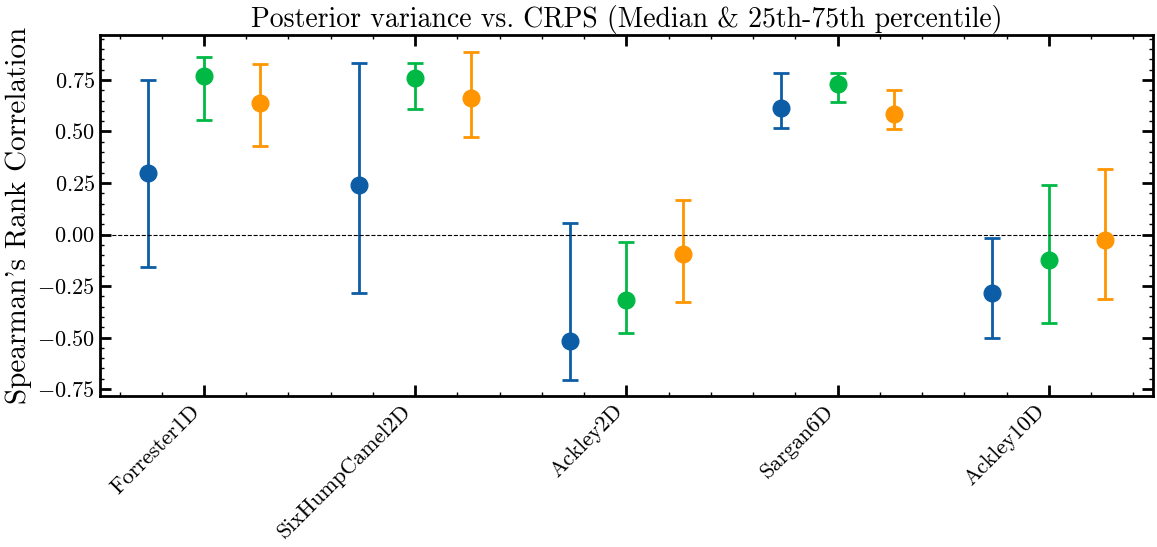

In [4]:
chosen_methods = [
    'None',
    'UNIBOv2',
    'ONLINEv2_e005'
]

custom_title = "Posterior variance vs. CRPS (Median & 25th-75th percentile)"

custom_legend_names = {
    'None': 'Vanilla BO',
    'UNIBOv2': 'Kuleshov et al. 2018',
    f'ONLINEv2_e005': 'Deshpande et al. 2024 ($\eta=0.05$)'
}

plot_correlation_summary_quantiles(
    raw_corr_df=per_run_corr_df,
    methods_to_plot=chosen_methods,
    corr_to_plot='postvar_vs_simpleregret',
    title=custom_title,
    label_map=custom_legend_names,
    show_legend=True,
    legend_loc= None,
    #save_path='../figs/presentation/posterior_variance_vs_simpleregret_ucb_noise_false.pdf',
)

In [5]:
metrics_to_average = ['y_regret_pool', 'crps_test', 'y_calibration_mse', 'online_calibration_mse' ,'mean_sharpness', 'posterior_variance', 'elpd', 'uct_sharpness', 'online_crps', 'calibration_optimum_local_y_mse', 'calibration_optimum_dist_bins']

results_df_ucb = load_all_results('../results_synth_data/UCB')
aggregated_df_ucb = aggregate_metrics(results_df_ucb, metrics_to_average)

Found 799 result files. Parsing...


  0%|          | 0/799 [00:00<?, ?it/s]

Aggregating results across seeds...


  0%|          | 0/80 [00:00<?, ?it/s]

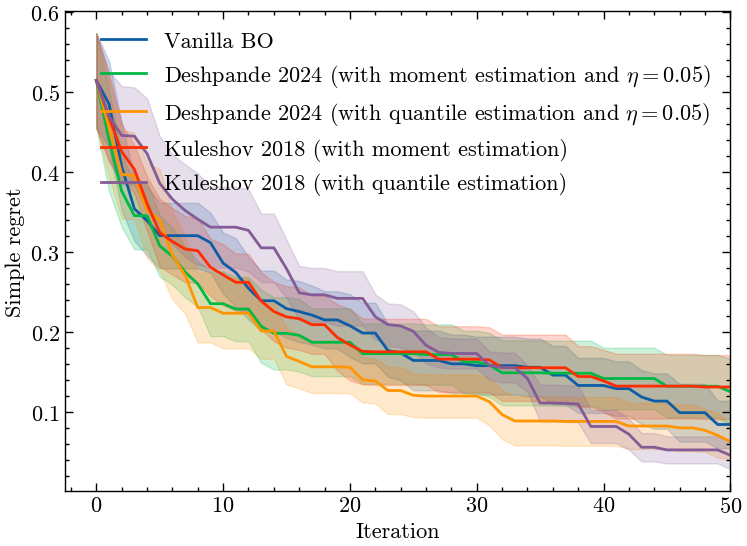

In [6]:
plot_metric_comparison(
    agg_df=aggregated_df_ucb,
    problem_name='SixHumpCamel2D',
    metric='y_regret_pool',
    n_initial=5,
    noisify=True,
    acquisition='UCB',
    quantile_level=0.95,
    methods_to_plot=[
        'None',
        'UNIBOv1',
        'UNIBOv2',
        'ONLINEv1_e005',
        'ONLINEv2_e005'
    ],
    zoom=False,
    show_legend=True
)